In [80]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2 as chi2_dist


Berekening van de Solid Angle

$$\Omega=\iint_S \frac{cos\alpha}{r^2}dS$$
$$w(\theta) = x_0 \,\cos\theta ,\\[2pt]$$
$$l         = y_0 ,\\[2pt]$$
$$h(\theta) = h_0 \,\cos\theta.$$

$$
\boxed{%
\Omega(\theta) \;=\;
4\;\arctan\!\biggl(
  \frac{\,w(\theta)\,l\,}
       {\,\dfrac{h(\theta)}{2}\;
        \sqrt{\,w(\theta)^2 + l^2 + \bigl(\tfrac{h(\theta)}{2}\bigr)^2}}
\biggr)
}
$$

Berekening van de Effectieve Oppervlakte

$$
\boxed{%
A(\theta) \;=\; w(\theta)\,l
            \;=\; x_0\,y_0\;\cos\theta
}
$$

In [81]:
# Grenzen in ns
BOVENGRENS = 10
ONDERGRENS = 0

x_0 = 4.5e-2
y_0 = 2.0e-1
h_0 = 8.6e-1
z_0  = 2.5e-2

def get_solid_angle(theta_deg: float, h=h_0) -> float:
    θ = math.radians(theta_deg)
    x_proj = x_0 * math.cos(θ)
    return 4 * math.atan(
        (x_proj * y_0) /
        ((h/2) * math.sqrt(x_proj**2 + y_0**2 + (h/2)**2))
    )

def get_effective_area(theta_deg: float) -> float:
    return 2 * (x_0 + z_0) * 2 * y_0# * math.cos(math.radians(theta_deg))

FOUTEN

In [82]:
# ─────────────────  extra onzekerheden  ─────────────────
ERR_H   = 0.005   # m   (± 5 mm onnauwkeurigheid h)
ERR_D   = 0.005   # m   (± 5 mm onnauwkeurigheid d)
SYS_REL = 0.07    # 3 % overige systematiek (temp, druk, gain…)

def geom_errors(angle_deg: float):
    """
    Berekent relatieve fout in solid_angle_ en A via eenvoudige finite differences
    op h ± ERR_H en d ± ERR_D.  Geeft terug:
        onderkerheid_rel_solid_angle, onderkerheid_rel_A,  solid_angle__nom, A_nom
    """
    theta = math.radians(angle_deg)
    d_nom = h_0 * math.tan(theta)

    solid_angle_0, A0 = get_solid_angle(d_nom), get_effective_area(d_nom)

    d_solid_angle_dh = (get_solid_angle(d_nom, h_0+ERR_H) - get_solid_angle(d_nom, h_0-ERR_H,)) / (2*ERR_H)
    d_solid_angle_dd = (get_solid_angle(d_nom+ERR_D) - get_solid_angle(d_nom-ERR_D)) / (2*ERR_D)

    onderkerheid_solid_angle_ = math.sqrt( (d_solid_angle_dh*ERR_H)**2 + (d_solid_angle_dd*ERR_D)**2 )
    onderkerheid_A = 0

    return onderkerheid_solid_angle_/solid_angle_0, onderkerheid_A/A0, solid_angle_0, A0


CSV FILES LEZEN EN FILTEREN

In [83]:

def analyse(path: Path):
    header = pd.read_csv(path, nrows=1)
    total_N = int  (header["Total coincidences"][0])
    runtime = float(header["Total runtime (s)"][0])

    parts  = path.stem.split("_")
    angle  = int(parts[1])
    side   = "C" if angle==0 else ("E" if "E" in parts else "W")
    comp   = "c1" if "c1" in parts else "c2"

    # Δt-lijst
    dt = pd.read_csv(path)["Delta times (ns)"].dropna().astype(float)
    if comp == "c2":           # sign-flip
        dt = -dt

    binnen = dt[(dt >= ONDERGRENS) & (dt <= BOVENGRENS)]
    N_binnen  = int(binnen.size)
    binnen = 100 * N_binnen / total_N if total_N else 0.0

    onzekerheid_rel_solid_angle, onzekerheid_rel_A, solid_angle, A = geom_errors(angle)
    flux_hdr = total_N / (runtime * A * solid_angle)

    sigma_stat = math.sqrt(total_N) / (runtime * A * solid_angle)
    sigma_geom = flux_hdr * math.sqrt(onzekerheid_rel_solid_angle**2 + onzekerheid_rel_A**2)
    sigma_sys  = SYS_REL * flux_hdr
    sigma_tot  = math.sqrt(sigma_stat**2 + sigma_geom**2 + sigma_sys**2)

    return dict(angle=angle, side=side, comp=comp,
                N_total=total_N, N_binnen=N_binnen, binnen_pct=binnen,
                runtime_s=runtime, flux=flux_hdr, sigma=sigma_tot)


csvs = sorted(Path(".").glob("hoek_*_c?.csv"))
if not csvs:
    raise FileNotFoundError("Geen hoek_*.csv in map gevonden.")

data = [analyse(f) for f in csvs]
df   = pd.DataFrame(data).sort_values(["angle","side","comp"])

TABEL VAN DE MEETUITKOMSTEN

In [84]:
pd.set_option("display.float_format", "{:.3f}".format)
cols = ["angle","side","comp","N_total","N_binnen","binnen_pct","flux","sigma"]
print("\n=== Muon-flux  (header)  + venster-info ======================")
print(df[cols].to_string(index=False))



=== Muon-flux  (header)  + venster-info ======================
 angle side comp  N_total  N_binnen  binnen_pct   flux  sigma
     0    C   c1     1675      1033      61.672 20.620  1.544
     0    C   c2     3357      1201      35.776 22.745  1.657
    10    E   c1     1627      1422      87.400 19.814  1.486
    10    E   c2     1882      1680      89.267 22.036  1.641
    10    W   c1     1152      1022      88.715 19.430  1.490
    10    W   c2     1265      1095      86.561 20.598  1.569
    20    E   c1     1299      1101      84.758 15.924  1.211
    20    E   c2     1122       987      87.968 13.225  1.016
    20    W   c1    12189      9615      78.883 16.918  1.207
    20    W   c2    15045     10871      72.257 19.088  1.360
    30    E   c1    27463     23078      84.033 11.195  0.795
    30    E   c2    27491     23170      84.282 11.214  0.797
    30    W   c1     9943      8293      83.405 11.257  0.805
    30    W   c2    11126      9414      84.613 12.596  0.900
    40

TABEL VAN DE FOUTEN

Statische Fout:         Alleen de pure telling-ruis √N (Poisson). Hoe langer je meet, hoe kleiner deze bijdrage.

Geometrische Fout:      Onzekerheid doordat h (tafel-hoogte) en d (horizontale verschuiving) niet exact bekend zijn.

Systematische Dout:     Alles wat niet in de twee vorige termen zit: temperatuurdaling, drukvariaties, PMT-gain- drift, kabelimpedanties.
                        Hier simpel gemodelleerd als een vaste 3% van de flux.

Totale Fout:            Alles wat niet in de twee vorige termen zit: temperatuurdaling, drukvariaties, PMT-gain- drift, kabelimpedanties … Hier simpel gemodelleerd als een vaste 3 % van de flux.

In [85]:
rows = []

for _, r in df.iterrows():
    angle  = r["angle"]
    comp   = r["comp"]
    side   = r["side"]
    N      = r["N_total"]
    t_run  = r["runtime_s"]
    flux   = r["flux"]

    # relatieve geometrische fouten opnieuw ophalen
    onzekerheid_rel_solid_angle, onzekerheid_rel_A, solid_angle, area = geom_errors(angle)

    # componenten
    onzekerheid_stat  = math.sqrt(N) / (t_run * area * solid_angle)
    onzekerheid_geom  = flux * math.sqrt(onzekerheid_rel_solid_angle**2 + onzekerheid_rel_A**2)
    onzekerheid_sys   = SYS_REL * flux
    onzekerheid_tot   = math.sqrt(onzekerheid_stat**2 + onzekerheid_geom**2 + onzekerheid_sys**2)

    rows.append(dict(
        angle = angle,
        side  = side,
        comp  = comp,
        flux  = flux,
        onzekerheid_stat = onzekerheid_stat,
        onzekerheid_geom = onzekerheid_geom,
        onzekerheid_sys  = onzekerheid_sys,
        onzekerheid_tot  = onzekerheid_tot
    ))

err_df = (pd.DataFrame(rows)
            .sort_values(["angle","side","comp"])
            .set_index(["angle","side","comp"]))

# nette weergave
# ---------------- nette opmaak zonder exponenten -----------------
fmt_fixed = {col: "{:.3f}".format for col in err_df.columns}

print("\n=== Foutopbouw per hoek / per computer ===")
print(err_df.to_string(formatters=fmt_fixed))




=== Foutopbouw per hoek / per computer ===
                  flux onzekerheid_stat onzekerheid_geom onzekerheid_sys onzekerheid_tot
angle side comp                                                                         
0     C    c1   20.620            0.504            0.217           1.443           1.544
           c2   22.745            0.393            0.240           1.592           1.657
10    E    c1   19.814            0.491            0.209           1.387           1.486
           c2   22.036            0.508            0.232           1.543           1.641
      W    c1   19.430            0.572            0.205           1.360           1.490
           c2   20.598            0.579            0.217           1.442           1.569
20    E    c1   15.924            0.442            0.168           1.115           1.211
           c2   13.225            0.395            0.139           0.926           1.016
      W    c1   16.918            0.153            0.178          

Grafieken Computer 1 en 2

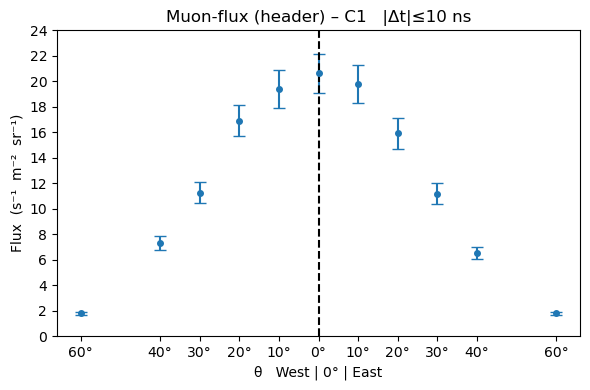

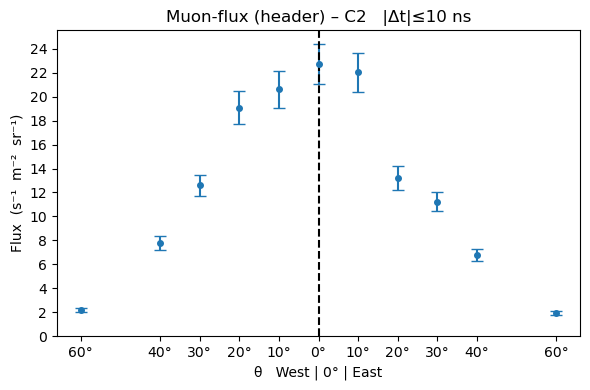

In [86]:
for pc in ["c1","c2"]:
    sub = df[df["comp"]==pc].copy()
    sub["x"] = np.where(sub["side"]=="W", -sub["angle"], sub["angle"])

    plt.figure(figsize=(6,4))
    plt.errorbar(sub["x"], sub["flux"], yerr=sub["sigma"],
                 fmt="o", capsize=4, linestyle="", markersize=4)
    plt.axvline(0, color="black", ls="--")
    plt.xticks(sub["x"], [f"{abs(v):.0f}°" for v in sub["x"]])
    plt.yticks(range(0, 26, 2))
    plt.xlabel("θ   West | 0° | East")
    plt.ylabel("Flux  (s⁻¹  m⁻²  sr⁻¹)")
    plt.title(f"Muon-flux (header) – {pc.upper()}   |Δt|≤{BOVENGRENS} ns")
    plt.tight_layout()
    plt.show()

FIT

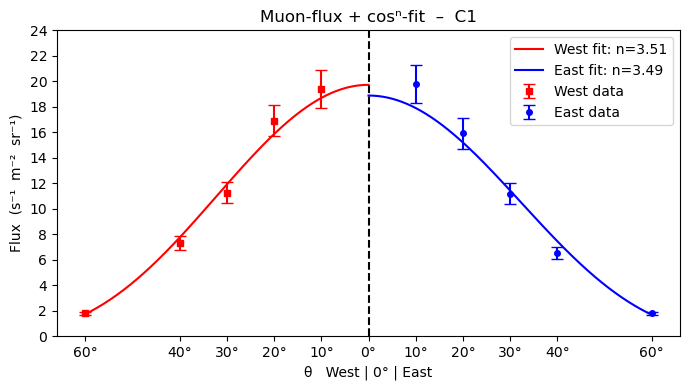

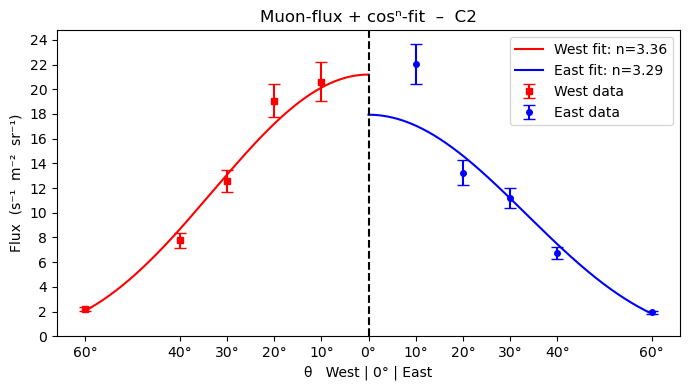

C1 E: A = 18.884 ± 0.902,  n = 3.487 ± 0.143,  χ² = 6.52, dof = 3, χ²_red = 2.17, p = 0.089
C1 W: A = 19.726 ± 0.924,  n = 3.506 ± 0.142,  χ² = 2.53, dof = 3, χ²_red = 0.84, p = 0.470
C2 E: A = 17.937 ± 0.860,  n = 3.294 ± 0.142,  χ² = 13.68, dof = 3, χ²_red = 4.56, p = 0.003
C2 W: A = 21.191 ± 0.996,  n = 3.358 ± 0.143,  χ² = 5.04, dof = 3, χ²_red = 1.68, p = 0.169


In [87]:
from scipy.optimize import curve_fit
from scipy.stats import chi2 as chi2_dist

def cosn(theta_deg, A, n):
    return A * np.cos(np.deg2rad(np.abs(theta_deg))) ** n

fit_dict = {}   # sleutel: (pc, side)  →  (popt, pcov)

for pc in ["c1", "c2"]:
    sub = df[df["comp"] == pc].copy()
    sub["x"] = np.where(sub["side"]=="W", -sub["angle"], sub["angle"])

    east = sub[sub["side"] == "E"]
    west = sub[sub["side"] == "W"]

    xE, yE, sE = east["angle"].values, east["flux"].values, east["sigma"].values
    xW, yW, sW = west["angle"].values, west["flux"].values, west["sigma"].values

    poptE, pcovE = curve_fit(cosn, xE, yE, p0=(yE.max(), 2),
                             sigma=sE, absolute_sigma=True)
    poptW, pcovW = curve_fit(cosn, xW, yW, p0=(yW.max(), 2),
                             sigma=sW, absolute_sigma=True)

    fit_dict[(pc,"E")] = (poptE, pcovE, xE, yE, sE)
    fit_dict[(pc,"W")] = (poptW, pcovW, xW, yW, sW)

    θ_grid = np.linspace(0, max(sub["angle"]), 300)
    plt.figure(figsize=(7,4))
    plt.errorbar(-xW, yW, yerr=sW, fmt="rs", markersize=4,
                 capsize=4, label="West data")
    plt.errorbar( xE, yE, yerr=sE, fmt="bo", markersize=4,
                 capsize=4, label="East data")
    plt.plot(-θ_grid, cosn(θ_grid,*poptW), "r-",
             label=f"West fit: n={poptW[1]:.2f}")
    plt.plot( θ_grid, cosn(θ_grid,*poptE), "b-",
             label=f"East fit: n={poptE[1]:.2f}")

    plt.axvline(0, color="k", ls="--")
    xt = sorted(sub["x"].unique())
    plt.xticks(xt, [f"{abs(t):.0f}°" for t in xt])
    plt.yticks(range(0, 26, 2))
    plt.xlabel("θ   West | 0° | East")
    plt.ylabel("Flux  (s⁻¹  m⁻²  sr⁻¹)")
    plt.title(f"Muon-flux + cosⁿ-fit  –  {pc.upper()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def chisq(y, f, s):
    return np.sum(((y - f) / s) ** 2)

for (pc, side), (popt, pcov, x, y, s) in fit_dict.items():
    y_fit = cosn(x, *popt)
    χ2    = chisq(y, y_fit, s)
    dof   = len(x) - len(popt)
    χ2red = χ2 / dof
    p_val = 1 - chi2_dist.cdf(χ2, dof)

    A, n = popt
    onzekerheid_A, onzekerheid_n = np.sqrt(np.diag(pcov))

    print(f"{pc.upper()} {side}: "
          f"A = {A:.3f} ± {onzekerheid_A:.3f},  "
          f"n = {n:.3f} ± {onzekerheid_n:.3f},  "
          f"χ² = {χ2:.2f}, dof = {dof}, χ²_red = {χ2red:.2f}, p = {p_val:.3f}")


In [88]:
def diff_table(pc):
    east = df.query("comp==@pc and side=='E'").set_index("angle")["flux"]
    west = df.query("comp==@pc and side=='W'").set_index("angle")["flux"]

    common = sorted(set(east.index) & set(west.index))
    rows = []
    for ang in common:
        IE, IW = east[ang], west[ang]
        delta  = IE - IW
        perc   = 100 * delta / ((IE + IW)/2)
        rows.append(dict(
            angle = ang,
            diff  = delta,
            pct   = perc
        ))
    return pd.DataFrame(rows).set_index("angle")

tbl_c1 = diff_table("c1").rename(columns={"diff":"Δ c1","pct":"%Δ c1"})
tbl_c2 = diff_table("c2").rename(columns={"diff":"Δ c2","pct":"%Δ c2"})

diff_df = tbl_c1.join(tbl_c2, how="outer").sort_index()

fmt = {
    "Δ c1":  "{:.2f}".format,
    "%Δ c1": "{:.2f}%".format,
    "Δ c2":  "{:.2f}".format,
    "%Δ c2": "{:.2f}%".format,
}

print("\nOost-West-verschil per hoek")
print(diff_df.to_string(formatters=fmt))




Oost-West-verschil per hoek
       Δ c1   %Δ c1  Δ c2   %Δ c2
angle                            
10     0.38   1.95%  1.44   6.75%
20    -0.99  -6.05% -5.86 -36.29%
30    -0.06  -0.55% -1.38 -11.60%
40    -0.74 -10.70% -1.01 -13.89%
60     0.00   0.09% -0.25 -12.00%
